# Quantum Kernels and Support Vector Machines

## Detecting Credit Card Fraud

Quantum Support Vector Machines (QSVM) on Kaggle labeled data is a means to classify and detect fraudulent credit card transactions.

Quantum Machine Learning (QML) is the aspect of research that explores the consequences of implementing machine learning on a quantum computer.

SVM is a supervised machine learning method widely used for multiple labeled data classification. The SVM algorithm can be enhanced even on a noisy intermediate scale quantum computer (NISQ) by introducing the kernel method. It can be restructured to exploit the properties of the large dimensionality of a quantum Hilbert space.

This demo presents a simple use case where a Quantum SVM (QSVM) algorithm is implemented on credit card labeled data to detect fraudulent transactions. It leverages the Classiq proprietary QSVM library and core capabilities to explore the rising potential in enhancing security applications.

This demonstration is based on work published in August 2022 [[1](#HBC)].

*This demo uses the `sklearn` package in addition to the `classiq` package.*

In [ ]:
!pip install -qq -U "classiq[qml]"

In [1]:
%%capture
! pip install scikit-learn
! pip install seaborn

Import the required resources:

In [2]:
# General Imports
# Visualization Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Scikit Imports
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [3]:
## For TSNE visualization
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE

# Hack the t-SNE code in sklearn 0.15.2
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import scale

# Random state
RS = 20150101

import matplotlib
import matplotlib.colors as colors

# Use Matplotlib for graphics
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt

# Import Seaborn to make nice plots
try:
    import seaborn as sns
except ModuleNotFoundError:
    palette = np.array(
        [
            (0.4, 0.7607843137254902, 0.6470588235294118),
            (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
            (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
            (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
            (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
            (1.0, 0.8509803921568627, 0.1843137254901961),
            (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
            (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
        ]
    )
else:
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = np.array(sns.color_palette("Set2"))

import warnings

warnings.filterwarnings("ignore")

In [4]:
from classiq import *

## Data

The dataset contains transactions made by credit cards in September 2013 by European cardholders. The transactions occurred over two days, where there were 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, such that the positive class (frauds) account for 0.172% of all transactions.

Data properties:
- The database contains only numeric input variables that are the result of a PCA transformation.
- Due to confidentiality issues, original features are not provided.
- Features V1, V2, … V28 are the principal components obtained with PCA.
- The only features that have not been transformed with PCA are 'Time' and 'Amount'.
- The 'Time' feature is the number of seconds that elapsed between each transaction and the first transaction in the dataset.
- The 'Amount' feature is the transaction amount.
- The 'Class' feature is the response variable. It takes the value of 1 in the case of fraud and 0 otherwise.

The data is freely available through Kaggle [[2](#Kaggle)].

### Loading the Kaggle "Credit Card Fraud Detection" Dataset

In [5]:
input_file = "../resources/creditcard.csv"
# comma delimited file as input
kaggle_full_set = pd.read_csv(input_file, header=0)
# presnting first 5 lines:
kaggle_full_set.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 1. Data Preprocessing: Selecting Train and Test Datasets

Subsample the dataset to make it manageable for near-term quantum simulations:

In [6]:
TRAIN_NOMINAL_SIZE = 100
TRAIN_FRAUD_SIZE = 25

TEST_NOMINAL_SIZE = 50
TEST_FRAUD_SIZE = 10

PREDICTION_NOMINAL_SIZE = 50
PREDICTION_FRAUD_SIZE = 10

SHUFFLE_DATA = False

In [7]:
## Separating nominal ("legit") from fraud:
all_fraud_set = kaggle_full_set.loc[kaggle_full_set["Class"] == 1]
all_nominal_set = kaggle_full_set.loc[kaggle_full_set["Class"] == 0]

In [8]:
## Optionally shuffle data before selective sets
if SHUFFLE_DATA:
    all_fraud_set = shuffle(all_fraud_set, random_state=1234)
    all_nominal_set = shuffle(all_nominal_set, random_state=1234)

In [9]:
## Selecting data subsets
selected_training_set = pd.concat(
    [all_nominal_set[:TRAIN_NOMINAL_SIZE], all_fraud_set[:TRAIN_FRAUD_SIZE]]
)
selected_testing_set = pd.concat(
    [
        all_nominal_set[TRAIN_NOMINAL_SIZE : TRAIN_NOMINAL_SIZE + TEST_NOMINAL_SIZE],
        all_fraud_set[TRAIN_FRAUD_SIZE : TRAIN_FRAUD_SIZE + TEST_FRAUD_SIZE],
    ]
)
selected_prediction_set = pd.concat(
    [
        all_nominal_set[
            TRAIN_NOMINAL_SIZE
            + TEST_NOMINAL_SIZE : TRAIN_NOMINAL_SIZE
            + TEST_NOMINAL_SIZE
            + PREDICTION_NOMINAL_SIZE
        ],
        all_fraud_set[
            TRAIN_FRAUD_SIZE
            + TEST_FRAUD_SIZE : TRAIN_FRAUD_SIZE
            + TEST_FRAUD_SIZE
            + PREDICTION_FRAUD_SIZE
        ],
    ]
)

In [10]:
## Separating relevant features data (excluding the "Time" column) from label data

kaggle_headers = list(kaggle_full_set.columns.values)  # all headers
feature_cols = kaggle_headers[1:-1]  # excluding Time and Class headers
label_col = kaggle_headers[-1]  # marking Class header as label

selected_training_data = selected_training_set.loc[:, feature_cols]
selected_training_labels = selected_training_set.loc[:, label_col]

selected_testing_data = selected_testing_set.loc[:, feature_cols]
selected_testing_labels = selected_testing_set.loc[:, label_col]

selected_prediction_data = selected_prediction_set.loc[:, feature_cols]
selected_prediction_true_labels = selected_prediction_set.loc[:, label_col]

### Visualizing the Selected Datasets with t-SNE

t-SNE is a technique for dimensionality reduction that is particularly suited for the visualization of high-dimensional datasets:

In [11]:
def scatter(x, colors):
    # Create a scatter plot
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect="equal")
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int32)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis("off")
    ax.axis("tight")

    # Add the labels for each digit
    txts = []
    labels = ["Nominal", "Fraud"]
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, labels[i], fontsize=24)
        txt.set_path_effects(
            [PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
        )
        txts.append(txt)

    return

#### TSNE Visualization of Train Data

Observe that visually t-SNE shows a separation between nominal and anomalous samples.

**However, the sole visualization map does not allow tracking of all fraudulent transactions.**

This demonstrates the challenge of high-quality fraud detection. 

For the sake of a quick demonstration, take only a very small percentage of the data. Applying better logic for subselecting the training and testing datasets affects the quality of the results:

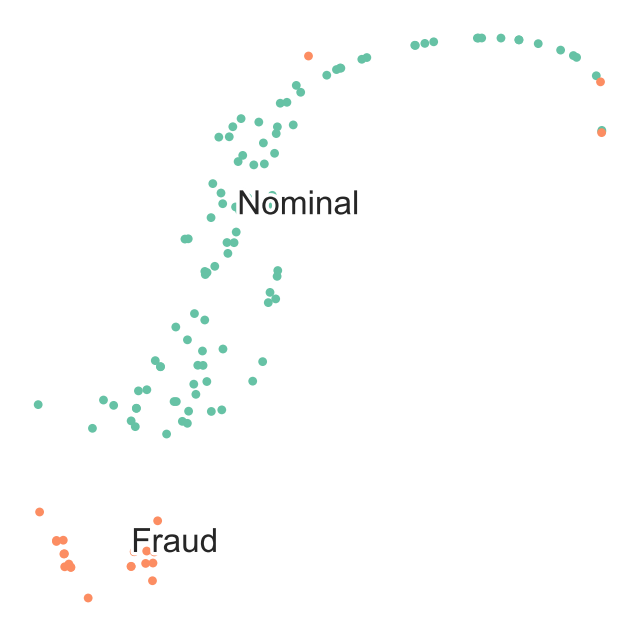

In [12]:
proj = TSNE(random_state=RS).fit_transform(selected_training_data)
scatter(proj, selected_training_labels)

#### TSNE Visualization of Test Data

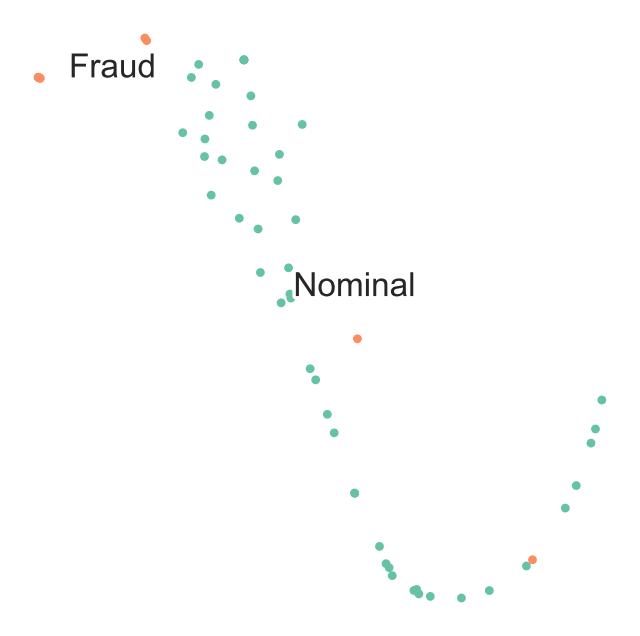

In [13]:
proj = TSNE(random_state=RS).fit_transform(selected_testing_data)
scatter(proj, selected_testing_labels)

### Reducing Dimensions

Convert original features into fewer features to match the number of qubits.

Perform dimensionality reduction to match the number of features with the number of qubits used in simulation. To do this, use principal component analysis and keep only the first *N_DIM* principal components:

In [14]:
## Choose a data dimension to encode
N_DIM = 3

In [15]:
sample_train = selected_training_data.values.tolist()
sample_test = selected_testing_data.values.tolist()
sample_predict = selected_prediction_data.values.tolist()

# Reduce dimensions

pca = PCA(n_components=N_DIM).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)
sample_predict = pca.transform(sample_predict)

### Normalizing

Use feature-wise standard scaling, i.e., subtract the mean and scale by the standard deviation for each feature:

In [16]:
# Normalize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)
sample_predict = std_scale.transform(sample_predict)

### Scaling

Scale each feature to a range between -$\pi$ and $\pi$:

In [17]:
# Scale
samples = np.append(sample_train, sample_test, axis=0)
samples = np.append(samples, sample_predict, axis=0)
minmax_scale = MinMaxScaler((-np.pi, np.pi)).fit(samples)
FRAUD_TRAIN_DATA = minmax_scale.transform(sample_train)
FRAUD_TEST_DATA = minmax_scale.transform(sample_test)
FRAUD_PREDICT_DATA = minmax_scale.transform(sample_predict)

This is the final preprocessed dataset:

In [18]:
FRAUD_TRAIN_LABELS = np.array(selected_training_labels.values.tolist())
FRAUD_TEST_LABELS = np.array(selected_testing_labels.values.tolist())

## 2. Map the Data to a Hilbert Space

The feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on n qubits.

Since the data may be non-linearly separable in the original space, the feature map circuit maps the classical data into the Hilbert space.

The choice of which feature map circuit to use is key and may depend on the given dataset to classify. You can leverage the Classiq feature map design capabilities.

### Designing a Feature Map
As an example, choose from the well known second-order Pauli-Z evolution encoding circuit with two repetitions or the bloch sphere circuit encoding. Their definitions are in the tutorials ([1](https://github.com/Classiq/classiq-library/blob/main/algorithms/qml/qsvm/qsvm.ipynb) and [2](https://github.com/Classiq/classiq-library/blob/main/algorithms/qml/qsvm_pauli_feature_map/qsvm_pauli_feature_map.ipynb)).

Pauli feature map:

In [19]:
from itertools import combinations

import numpy as np


def generate_connectivity_map(list_size, sublist_size, connectivity_type):
    """
    Generate connectivity for a given list size and sublist size.

    Parameters:
    - list_size: The size of the list (number of elements).
    - sublist_size: The size of the subsets to generate.
    - connectivity_type: an integer (0 for linear, 1 for circular, 2 for full)

    Returns:
    - A list of all unique subsets of the given size.
    """
    assert connectivity_type in [
        0,
        1,
        2,
    ], "connectivity must be 0 (linear), 1 (circular), or 2 (full)"

    if connectivity_type == 0:  # linear
        return [
            list(range(i, i + sublist_size))
            for i in range(list_size - sublist_size + 1)
        ]

    elif connectivity_type == 1:  # circular
        return [
            [(i + j) % list_size for j in range(sublist_size)] for i in range(list_size)
        ]

    elif connectivity_type == 2:  # full
        return [list(comb) for comb in combinations(range(list_size), sublist_size)]


def generate_hamiltonian(
    data: CArray[CReal],
    paulis_list: list[list[Pauli]],
    affines: list[list[float]],
    connectivity: int,
) -> tuple[list[SparsePauliOp], list[CReal]]:
    assert connectivity in [
        0,
        1,
        2,
    ], "connectivity must be 0 (linear), 1 (circular) or 2 (full)"
    hs = []
    coeffs = []
    for paulis, affine in zip(paulis_list, affines):
        indices = generate_connectivity_map(data.len, len(paulis), connectivity)
        for k in range(len(indices)):
            indexed_paulis = [
                IndexedPauli(pauli=paulis[j], index=indices[k][j])
                for j in range(len(indices[0]))
            ]
            hs.append(
                SparsePauliOp(
                    terms=[SparsePauliTerm(paulis=indexed_paulis, coefficient=1)],
                    num_qubits=data.len,
                )
            )
            coe = np.prod(
                [
                    affine[0] * (data[indices[k][j]] - affine[1])
                    for j in range(len(indices[0]))
                ]
            )
            coeffs.append(coe)

    return hs, coeffs


@qfunc
def pauli_kernel(
    data: CArray[CReal],
    paulis_list: list[list[Pauli]],
    affines: list[list[float]],
    connectivity: int,
    reps: CInt,
    qba: QArray,
) -> None:
    hs, coeffs = generate_hamiltonian(data, paulis_list, affines, connectivity)
    power(
        reps,
        lambda: (
            hadamard_transform(qba),
            multi_suzuki_trotter(
                hamiltonians=hs,
                evolution_coefficients=coeffs,
                order=1,
                repetitions=1,
                qbv=qba,
            ),
        ),
    )

Bloch sphere feature map:

In [20]:
from classiq.qmod.symbolic import ceiling, floor


@qfunc
def bloch_feature_map(data: CArray[CReal], qba: QArray[QBit]):
    repeat(ceiling(data.len / 2), lambda i: RX(data[2 * i] / 2, qba[i]))
    repeat(floor(data.len / 2), lambda i: RZ(data[(2 * i) + 1], qba[i]))

Construct the quantum model for the QSVM routine:

In [21]:
## Choose "bloch sphere" feature map encoding:


@qfunc
def main(
    data1: CArray[CReal, N_DIM],
    data2: CArray[CReal, N_DIM],
    qba: Output[QNum],
):

    allocate(ceiling(data1.len / 2), qba)
    bloch_feature_map(data1, qba)
    invert(lambda: bloch_feature_map(data2, qba))


QSVM_FRAUD_BLOCH_SHPERE = create_model(main)

## Choose "Pauli ZZ" feature map encoding with 2 repetitions:
PAULIS = [[Pauli.Z], [Pauli.Z, Pauli.Z]]
CONNECTIVITY = 2  # Full
AFFINES = [[1, 0], [1, np.pi]]
REPS = 2


@qfunc
def main(data1: CArray[CReal, N_DIM], data2: CArray[CReal, N_DIM], qba: Output[QNum]):
    allocate(data1.len, qba)
    pauli_kernel(data1, PAULIS, AFFINES, CONNECTIVITY, REPS, qba)
    invert(lambda: pauli_kernel(data2, PAULIS, AFFINES, CONNECTIVITY, REPS, qba))


QSVM_FRAUD_PAULI_ZZ = create_model(main)
write_qmod(QSVM_FRAUD_PAULI_ZZ, "credit_card_fraud", symbolic_only=False)

### Synthesizing the Model and Exploring the Generated Quantum Circuit
Now that you have constructed the QSVM model, synthesize and view the quantum circuit that encodes the data using the Classiq built-in `synthesize` and `show` functions:

In [22]:
qprog = synthesize(QSVM_FRAUD_PAULI_ZZ)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/30HZCFioCUPSKpGcWwBkA6VYkwj


## 3. Execute QSVM

Quantum Support Vector Machines is the quantum version of SVM: a data classification method that separates the data using a hyperplane.

The algorithm performs these steps [[3](#3)]:

1. **Estimates** the kernel matrix:

    - A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close.

    - When considering finite data, you can represent the quantum kernel as a matrix:
    $K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$.

        Calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
        $$
        \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} =
        \left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
        $$

        This provides an estimate of the quantum kernel matrix, which will be used in the support vector classification.


2. **Optimizes** the dual problem using the classical SVM algorithm to generate a separating hyperplane and classify the data:
$$ L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\vec{x}_i \vec{x}_j) $$ where
    - $t$ is the number of data points
    - $\vec{x}_i$s are the data points
    - $y_i$ is the label $\in \{-1,1\}$ of each data point
    - $K(\vec{x}_i \vec{x}_j)$ is the kernel matrix element between the $i$ and $j$ data points
    - Optimizes over the $\alpha$s
   


   Expect most of the $\alpha$s to be $0$. The $\vec{x}_i$s that correspond to non-zero $\alpha_i$ are called the support vectors.

### Setting Up the Classiq QSVM Postprocess Routine

In [23]:
def get_execution_params(data1, data2=None):
    """
    Generate execution parameters based on the mode (train or validate).

    Parameters:
    - data1: First dataset (used for both training and validation).
    - data2: Second dataset (only required for validation).

    Returns:
    - A list of dictionaries with execution parameters.
    """
    if data2 is None:
        # Training mode (symmetric pairs of data1)
        return [
            {"data1": data1[k], "data2": data1[j]}
            for k in range(len(data1))
            for j in range(k, len(data1))  # Avoid symmetric pairs
        ]
    else:
        # Prediction mode
        return [
            {"data1": data1[k], "data2": data2[j]}
            for k in range(len(data1))
            for j in range(len(data2))
        ]


def construct_kernel_matrix(matrix_size, res_batch, train=False):
    """
    Construct a kernel matrix from `res_batch`, depending on whether it's for training or predicting.

    Parameters:
    - matrix_size: Tuple of (number of rows, number of columns) for the matrix.
    - res_batch: Precomputed batch results.
    - train: Boolean flag. If True, assumes training (symmetric matrix).

    Returns:
    - A kernel matrix as a NumPy array.
    """
    rows, cols = matrix_size
    kernel_matrix = np.zeros((rows, cols))

    num_shots = res_batch[0].num_shots
    num_output_qubits = len(next(iter(res_batch[0].counts)))

    count = 0
    if train:  # and rows == cols:
        # Symmetric matrix (training)
        for k in range(rows):
            for j in range(k, cols):
                value = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                kernel_matrix[k, j] = value
                kernel_matrix[j, k] = value  # Use symmetry
                count += 1
    else:
        # Non-symmetric matrix (validation)
        for k in range(rows):
            for j in range(cols):
                kernel_matrix[k, j] = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                count += 1

    return kernel_matrix


def train_svm(es, train_data, train_labels):
    """
    Trains an SVM model using a custom precomputed kernel from the training data.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - train_data: List of data points for training.
    - train_labels: List of binary labels corresponding to the training data.

    Returns:
    - svm_model: A trained SVM model using the precomputed kernel.
    """
    train_size = len(train_data)
    train_execution_params = get_execution_params(train_data)
    res_train_batch = es.batch_sample(train_execution_params)  # execute batch
    # generate kernel matrix for train
    kernel_train = construct_kernel_matrix(
        matrix_size=(train_size, train_size), res_batch=res_train_batch, train=True
    )
    svm_model = SVC(kernel="precomputed")
    svm_model.fit(
        kernel_train, train_labels
    )  # the fit gets the precomputed matrix of training, and the training labels

    return svm_model


def predict_svm(es, data, train_data, svm_model):
    """
    Predicts labels for new data using a precomputed kernel with a trained SVM model.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - data (list): List of new data points to predict.
    - train_data (list): Original training data used to train the SVM.
    - svm_model: A trained SVM model returned by `train_svm`.

    Returns:
    - y_predict (list): Predicted labels for the input data.
    """
    predict_size = len(data)
    train_size = len(train_data)
    predict_execution_params = get_execution_params(data, train_data)
    res_predict_batch = es.batch_sample(predict_execution_params)  # execute batch
    kernel_predict = construct_kernel_matrix(
        matrix_size=(predict_size, train_size), res_batch=res_predict_batch, train=False
    )
    y_predict = svm_model.predict(
        kernel_predict
    )  # the predict gets the precomputed test matrix

    return y_predict

### Running QSVM and Analyzing the Results



### Training and Testing the Data

1. Build the train and test quantum kernel matrices:
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability}: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.


Execute QSVM using the `batch_sample` of the `ExecutionSession` object, as defined in the classical postprocess functions above. Consider the accuracy of the classification and the predicted labels for the predict data:


In [24]:
from classiq.execution import ExecutionSession

with ExecutionSession(qprog) as es:
    # train
    svm_model = train_svm(es, FRAUD_TRAIN_DATA.tolist(), FRAUD_TRAIN_LABELS.tolist())

    # test
    y_test = predict_svm(
        es, FRAUD_TEST_DATA.tolist(), FRAUD_TRAIN_DATA.tolist(), svm_model
    )
    test_score = sum(y_test == FRAUD_TEST_LABELS.tolist()) / len(
        FRAUD_TEST_LABELS.tolist()
    )

    # predict
    predicted_labels = predict_svm(
        es, FRAUD_PREDICT_DATA.tolist(), FRAUD_TRAIN_DATA.tolist(), svm_model
    )

In [25]:
print("quantum kernel classification test score:  %0.2f" % (test_score))

quantum kernel classification test score:  0.92


The result seems OK. This is a good start! 
### Analyzing
Now analyze further by comparing the testing accuracy results to classical kernels:

In [26]:
classical_kernels = ["linear", "poly", "rbf", "sigmoid"]

for ckernel in classical_kernels:
    classical_svc = SVC(kernel=ckernel)
    classical_svc.fit(FRAUD_TRAIN_DATA, FRAUD_TRAIN_LABELS)
    classical_score = classical_svc.score(
        FRAUD_TEST_DATA, np.array(FRAUD_TEST_LABELS.tolist())
    )

    print("%s kernel classification test score:  %0.2f" % (ckernel, classical_score))

linear kernel classification test score:  1.00
poly kernel classification test score:  1.00
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  0.98


Given the simple naive training and testing set example, the statement that **quantum kernel gets results at least as good as the classical kernels** can be interpreted as a promising sign and encouragement towards deeper research. Bear in mind:
- Quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate classically (a necessary and not always sufficient condition to obtain a quantum advantage).

- However, it was recently proven [[4](#4)] that learning problems exist for which learners with access to quantum kernel methods have a quantum advantage over all classical learners.

### Predicting Data

Finally, predict unlabeled data by calculating the kernel matrix of the new datum with respect to the support vectors:
    $$ \text{Predicted Label}(\vec{s}) = \text{sign} \left( \sum_{i=1}^t y_i \alpha_i^* K(\vec{x}_i , \vec{s}) + b \right) $$    
    
where 
    - $\vec{s}$ is the datapoint to classify
    - $\alpha_i^*$ are the optimized $\alpha$s
    - $b$ is the bias

In [27]:
true_labels = np.array(selected_prediction_true_labels.values.tolist())
sklearn.metrics.accuracy_score(predicted_labels, true_labels)

0.9166666666666666

## Quantum Advantage Is Possible

QSVM has the potential to enhance performance, accuracy, and even efficiency in resources:

- There are limitations to the successful classical solutions when the feature space becomes large and the kernel functions become computationally expensive to estimate.

- For certain types of data, a classifier that exploits the quantum feature space shows better results.

- A necessary condition to obtain a quantum advantage is that the kernel cannot be estimated classically. Since quantum computers are not expected to be classically simulable there is a very large design space to explore.

It becomes intriguing to find suitable feature maps for this technique with provable quantum advantages while providing significant improvement on real world datasets. With the ubiquity of kernel methods in machine learning, in the future the techniques may produce applications even beyond binary classification.


## References

<a id='1'>[1]</a> [Oleksandr Kyriienko, Einar B. Magnusson. (2022). Unsupervised quantum machine learning for fraud detection. Preprint.](https://arxiv.org/abs/2208.01203)

<a id='Kaggle'>[2]</a> [Kaggle dataset - Credit Card Fraud Detection:
Anonymized credit card transactions labeled as fraudulent or genuine.](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

<a id='3'>[3]</a> [Havl&#237;&#269;ek, V., C&#243;rcoles, A.D., Temme, K. et al. (2019). Supervised learning with quantum-enhanced feature spaces. Nature 567, 209-212.](https://doi.org/10.1038/s41586-019-0980-2)

<a id='4'>[4]</a> [Liu et al. (2020). A rigorous and robust quantum speed-up in supervised machine learning.](https://arxiv.org/pdf/2010.02174.pdf)
